# Linear regression
内容包括：（1）数据处理（2）模型（3）损失函数（4）小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


# 生成数据集
方便起见，打造人造数据集
- 数据集一共含有**1000**条数据
- 每个样本包含两个特征（低维，方便可视化）
- 含有噪声的线性回归，$\epsilon$ 服从正态分布，$\epsilon\sim\mathcal(N)(0,\sigma^2)$
在正式解决问题前，先确定需要还原的参数 $\bf w=[2,3,-4]^T$ $b=4.2$
线性模型的公式为： ${\bf y=Xw}+b+\epsilon$

In [16]:
def synthetic_data(w,b,num_examples):
    '''生成噪声'''
    X = torch.normal(0,1,(num_examples,len(w))) # generate input, shape: (n,d)
    y = torch.matmul(X,w)+b # linear regression
    y += torch.normal(0,0.01,y.shape) # generate noise and add it to y function
    
    return X,y.reshape((-1,1)) # reshape y as column vector and add it to y function

In [30]:
true_w = torch.tensor([2,-3.4],dtype=torch.float32)
true_b = 4.2
# fetch inputs and expected outputs
features,labels = synthetic_data(true_w,true_b,1000) 
print(f"features: {features[0]} labels: {labels[0]}")


features: tensor([ 0.3381, -1.2103]) labels: tensor([8.9911])


通过生成散点图，查看自变量与因变量之间关系

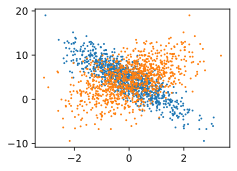

In [31]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);
d2l.plt.scatter(features[:,0].detach().numpy(),labels.detach().numpy(),1);

可以看到大致呈线性关系

# 读取数据集
小批量抽取样本，进行更新。
因此需要定义一个函数，能够：
- 打乱数据集中的样本
- 抽取小批量数据

In [32]:
def data_iter(batch_size,features,labels):
    '''参数：批量大小 特征矩阵 标签向量
        作用：生成并返回对应批量大小的数据
    '''
    num_examples = len(features) # 数据总量
    indices = list(range(num_examples)) # 每个数据编号
    random.shuffle(indices) # 打乱样本编号
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

利用GPU的并行计算能力，每次抽取小批量样本时，每个样本都可以并行地进行模型计算，并且每个样本的损失函数的梯度也可以并行计算。
一般来说，当硬件资源允许时，可以将batch_size设置地大一些。
batch_size，在一个批量内计算的次数就越多，但是更新的次数就越少
batch_size越小，在一个批量内计算的次数就越少，但是更新的次数就越多。
实验证明，更新次数越多，训练所需的时间越长。

In [33]:
# 测试分批抽取样本函数
# data_iter相当于已实现好的 Dataloader
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
    

tensor([[ 0.2322,  1.0365],
        [-0.1045,  2.5636],
        [ 2.7300,  0.3195],
        [-0.9914, -1.7241],
        [ 0.0821,  0.6796],
        [ 1.0570,  1.1324],
        [-1.4109, -0.4870],
        [ 1.8191,  0.4742],
        [ 0.4636, -0.7744],
        [ 1.5066, -0.4190]]) 
 tensor([[ 1.1496],
        [-4.7323],
        [ 8.5662],
        [ 8.0707],
        [ 2.0332],
        [ 2.4632],
        [ 3.0330],
        [ 6.2276],
        [ 7.7486],
        [ 8.6327]])


# 初始化模型参数
线性模型需要找到最优的参数 $\bf w$ 与 $b$ ，而在最开始时，可以先随机初始化这两个参数，从 $\mathcal{N}(0,0.01)$ 中采样，初始化 $\bf w$ ，将 $b$ 置为0

不过由 $L$ 对 $\bf w$ 和 $b$ 的偏导可知，即使 $\bf w$ 初始化为0，偏导数也不会为0，仍然可以正常更新优化。

In [63]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
#w = torch.zeros((2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

# 定义模型
接下来的任务就是更新参数，使用随机小批量梯度下降的方法，用autograd自动计算梯度
- 定义损失函数
- 定义优化算法


In [57]:
def linreg(X,w,b):
    '''线性回归模型'''
    return torch.matmul(X,w) + b 

In [58]:
def squared_loss(y_hat,y):
    '''平方误差'''
    return (y_hat - y.reshape(y_hat.shape))**2/2 # reshape保证形状一致

In [59]:
def sgd(params,lr,batch_size):
    '''小批量随机梯度下降，先计算梯度，然后同时更新参数'''
    with torch.no_grad():
        for param in params:
            param -= (lr * param.grad / batch_size) # lr乘上平均梯度
            param.grad.zero_() # 清空梯度

# 训练
重要部分，在深度学习中一直出现，主要内容包括：
- 读取小批量样本
- 前向传播，通过目前参数得到输出
- 反向传播，存储每个参数梯度，更新参数

流程：
- 初始化参数
- 重复如下训练，直到达到最大迭代次数或精度达到要求
    - 计算梯度
    - 更新参数( $\bf w$ $b$ )

在每个迭代周期 $epoch$ 里，都会遍历整个数据集，遍历次数为 $num\_examples/batch\_size$

在训练时，超参数 $lr$ $batch_size$ $epoch$ 需要手动指定，较为麻烦，需要选择不同组合来寻找最优的超参数

In [60]:
# 设置超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [61]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # 前向传播计算loss
        l.sum().backward() # 反向传播计算梯度
        sgd([w,b],lr,batch_size) # 小批量随机梯度下降更新参数
    # 计算每个epoch中验证集s的损失值
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031811
epoch 2, loss 0.000113
epoch 3, loss 0.000050


# 结束
通过比较真实参数与训练所的参数之间的差异，评估模型的性能

In [62]:
print(f"w的估计误差: {true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差: {true_b - b}")

w的估计误差: tensor([-0.0004, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0005], grad_fn=<RsubBackward1>)


深度学习中，目标并不是准确地拟合正确的参数，而是高度准确地预测参数。使用SGD的方法，即使是复杂的优化问题，也能够找到很好的解。

其中一个原因是：深度网络中存在很多种可能的参数组合，能让模型的性能达到很好的表现